In [43]:
import os
import zipfile
import joblib as pkl
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

In [44]:
def pickle(value = None, filename = None):
    if value and filename:
        pkl.dump(value = value, filename=filename)
    else:
        raise ValueError("value and filename are required".capitalize())
    
def clean(path = None):
    if path:
        for file in os.listdir(path):
            os.remove(os.path.join(path, file))
    else:
        raise ValueError("path is required".capitalize())
    
def total_params(model = None):
    return sum(p.numel() for p in model.parameters())


In [45]:
to_extract = "../data/raw/"
to_save = "../data/processed/"

In [47]:
class Loader:
    def __init__(self, image_path = None, batch_size = 64, image_size = 64, normalized = True):
        self.image_path = image_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.use_normalized = normalized

    def unzip_images(self):
        with zipfile.ZipFile(self.image_path, "r") as zip_ref:
            if os.path.exists(to_extract):
                zip_ref.extractall(to_extract)
            else:
                raise Exception("Extracting images failed".capitalize())

    def _normalized(self):
        if self.use_normalized:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(self.image_size),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 5, 0.5]),
                transforms.Grayscale(num_output_channels=1)
            ])

            return transform

    @staticmethod
    def class_to_idx(dataset = None):
        if dataset is not None:
            return dataset.class_to_idx

    def create_dataloader(self):
        if os.path.exists(to_extract):
            datasets = ImageFolder(root=os.path.join(to_extract, "Dataset"), transform=self._normalized())
            dataloader = DataLoader(datasets, batch_size=self.batch_size, shuffle=True)

            if os.path.exists(to_save):

                try:
                    pickle(value=dataloader, filename=os.path.join(to_save, "dataloader.pkl"))
                    pickle(value=Loader.class_to_idx(dataset=datasets), filename=os.path.join(to_save, "dataset.pkl"))
                except Exception as e:
                    print(e)
            else:
                raise Exception("Creating dataloader failed".capitalize())
        else:
            raise Exception("Extracting images failed from the create dataloader method".capitalize())

        return dataloader, datasets.class_to_idx


if __name__ == "__main__":
    loader = Loader(
        image_path="/Users/shahmuhammadraditrahman/Desktop/archive.zip",
        batch_size=64,
        image_size=64,
        normalized=True,
    )

    loader.unzip_images()
    dataloader, labels = loader.create_dataloader()

In [50]:
dataloader

#### Create the Generator model

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class Generator(nn.Module):
    def __init__(self, latent_space = 50, num_labels = 4, image_size = 64, in_channels = 1):
        self.latent_space = latent_space
        self.num_labels = num_labels
        self.image_size = image_size
        self.in_channels = in_channels

        super(Generator, self).__init__()
        self.config_layers = [
            (self.latent_space * 2, self.image_size * 8, 4, 1, 0, True, False),
            (self.image_size * 8, self.image_size * 4, 4, 2, 1, True, False),
            (self.image_size * 4, self.image_size * 2, 4, 2, 1, True, False),
            (self.image_size * 2, self.image_size, 4, 2, 1, True, False),
            (self.image_size, self.in_channels, 4, 2, 1, False, False),
        ]
        self.labels = nn.Embedding(num_embeddings=self.num_labels, embedding_dim=self.latent_space)
        self.model = self.connected_layer(config_layers=self.config_layers)
        
    def connected_layer(self, config_layers = None):
        if config_layers is not None:
            layers = OrderedDict()
            
            for idx, (in_channels, out_channels, kernel_size, stride, padding, batch_norm, bias) in enumerate(config_layers[:-1]):
                layers[f"ConvTranspose{idx+1}"] = nn.ConvTranspose2d(
                    in_channels, out_channels, kernel_size, stride, padding, bias=bias)
                
                if batch_norm:
                    layers[f"BatchNorm{idx+1}"] = nn.BatchNorm2d(out_channels)
                    
                layers[f"ReLU{idx+1}"] = nn.ReLU(inplace=True)
            
            in_channels, out_channels, kernel_size, stride, padding, batch_norm, bias = config_layers[-1]
            layers[f"outConvTranspose"] = nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=bias)
            layers["outLayer"] = nn.Tanh()
            
            return nn.Sequential(layers)
        
        else:
            raise ValueError("config layer should be defined".capitalize())

    def forward(self, noise, labels):
        labels = self.labels(labels)
        labels = labels.view(labels.size(0), self.latent_space, 1, 1)
        return self.model(torch.cat((noise, labels), dim=1))


if __name__ == "__main__":
    net_G = Generator()
    labels = torch.randint(0, 4, (64,))
    noise = torch.randn(64, 50, 1, 1)
    
    print(net_G(noise, labels).shape)
    print(total_params(model=net_G))

torch.Size([64, 1, 64, 64])
3574856


##### Define the Discriminator model

In [31]:
class Discriminator(nn.Module):
    def __init__(self, in_channels = 1, num_labels = 4, image_size = 64):
        self.in_channels = in_channels
        self.num_labels = num_labels
        self.image_size = image_size
        
        super(Discriminator, self).__init__()
        
        self.config_layers = [
            (self.in_channels, self.image_size, 4, 2, 1, False),
            (self.image_size, self.image_size*2, 4, 2,1, True),
            (self.image_size*2, self.image_size*4, 4, 2, 1, True),
            (self.image_size*4, self.image_size*8, 4, 2, 1, True),
            (self.image_size*8, 1 + self.num_labels, 4, 1, 0)
            
        ]
        
        self.model = self.connected_layer(config_layers=self.config_layers)
        
    
    def connected_layer(self, config_layers = None):
        if config_layers is not None:
            layers = OrderedDict()
            
            for idx, (in_channels, out_channels, kernel_size, stride, padding, batch_norm) in enumerate(config_layers[:-1]):
                layers['conv{}'.format(idx+1)] = nn.Conv2d(
                    in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
                if batch_norm:
                    layers[f"batchNorm{idx+1}"] = nn.BatchNorm2d(num_features=out_channels)
                    
                layers[f"leaky_relu{idx+1}"] = nn.LeakyReLU(negative_slope=0.2, inplace=True)
                
            (in_channels, out_channels, kernel_size, stride, padding) = config_layers[-1]
            layers["out"] = nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
            
            return nn.Sequential(layers)
                
        else:
            raise ValueError("config layer should be defined".capitalize())
        
    
    def forward(self, x):
        output = self.model(x)
        real_or_fake = output[:, 0:1]
        labels = output[:, 1:]
        return torch.sigmoid(real_or_fake.view(-1, 1)), F.log_softmax(labels.view(-1, self.num_labels))
    

if __name__ == "__main__":
    
    net_D = Discriminator()
    
    noise_data = torch.randn(64, 1, 64, 64)
    real_fake, labels = net_D(noise_data)
    print(real_fake.shape, labels.shape)
    print(total_params(net_D))

torch.Size([64, 1]) torch.Size([64, 4])
2796288


/var/folders/_6/fpk79cm53rxgcj2gh5prtww00000gn/T/ipykernel_3006/286996701.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.sigmoid(real_or_fake.view(-1, 1)), F.log_softmax(labels.view(-1, self.num_labels))


#### Define the loss and optimizer

In [55]:
import torch.optim as optim

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

net_G = Generator().to(device)
net_D = Discriminator().to(device)

optimizer_G = optim.Adam(net_G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(net_D.parameters(), lr=0.0002, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()

#### Train the model

In [56]:
# class Trainer:
#     def __init__(self, num_epochs = 200, latent_space = 50):
#         self.num_epochs = num_epochs
#         self.latent_space = latent_space

#     def train(self):
#         for epoch in range(self.num_epochs):
#             for idx, (real_images, labels) in enumerate(dataloader):
#                 real_images = real_images.to(device)
#                 labels = labels.to(device)

#                 batch_size = real_images.shape[0]

#                 real_labels = torch.ones(batch_size, 1).to(device)
#                 fake_labels = torch.zeros(batch_size, 1).to(device)
#                 gen_labels = torch.randint(0, 4, (batch_size,), dtype=torch.long).to(device)
#                 noise_samples = torch.randn(batch_size, self.latent_space, 1, 1).to(device)

#                 # Train the Discriminator
#                 optimizer_D.zero_grad()

#                 real_predict, real_aux_labels = net_D(real_images)
#                 real_loss = adversarial_loss(real_predict, real_labels)
#                 real_aux_loss = auxiliary_loss(real_aux_labels, labels)

#                 total_real_loss = real_loss + real_aux_loss

#                 fake_samples = net_G(noise_samples, gen_labels)
#                 fake_predict, fake_aux_labels = net_D(fake_samples.detach())
#                 fake_loss = adversarial_loss(fake_predict, fake_labels)
#                 fake_aux_loss = auxiliary_loss(fake_aux_labels, gen_labels)

#                 total_fake_loss = fake_loss + fake_aux_loss

#                 total_D_loss = 0.5 * (total_real_loss + total_fake_loss)

#                 total_D_loss.backward()
#                 optimizer_D.step()

#                 # Train the generator
#                 optimizer_G.zero_grad()
                
#                 generated_predict, generated_aux_labels = net_D(fake_samples)
#                 generated_loss = adversarial_loss(generated_predict, real_labels)
#                 generated_aux_loss = auxiliary_loss(generated_aux_labels, gen_labels)

#                 total_G_loss = 0.5 * generated_loss + 0.5 * generated_aux_loss
                
#                 total_G_loss.backward()
#                 optimizer_G.step()

#                 if idx % 50 == 0:
#                     print("[Epoch - {}/{}] - [Steps - {}/{}] G_loss: {} - D_loss: {}".format(
#                         epoch+1, self.num_epochs, idx, len(dataloader), total_G_loss.item(), total_D_loss.item())
#                     )                


# if __name__ == '__main__':
#     trainer = Trainer()
#     trainer.train()

/var/folders/_6/fpk79cm53rxgcj2gh5prtww00000gn/T/ipykernel_3006/286996701.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.sigmoid(real_or_fake.view(-1, 1)), F.log_softmax(labels.view(-1, self.num_labels))


[Epoch - 1/200] - [Steps - 0/100] G_loss: 1.3004992008209229 - D_loss: 2.085245370864868
[Epoch - 1/200] - [Steps - 50/100] G_loss: 3.0883748531341553 - D_loss: 0.7800776362419128
[Epoch - 2/200] - [Steps - 0/100] G_loss: 2.0429787635803223 - D_loss: 1.1105945110321045
[Epoch - 2/200] - [Steps - 50/100] G_loss: 1.3600430488586426 - D_loss: 1.0374438762664795
[Epoch - 3/200] - [Steps - 0/100] G_loss: 1.7724591493606567 - D_loss: 0.8941222429275513
[Epoch - 3/200] - [Steps - 50/100] G_loss: 1.4744912385940552 - D_loss: 0.765568196773529
[Epoch - 4/200] - [Steps - 0/100] G_loss: 1.2245457172393799 - D_loss: 0.821340799331665
[Epoch - 4/200] - [Steps - 50/100] G_loss: 0.5957700610160828 - D_loss: 0.726230800151825
[Epoch - 5/200] - [Steps - 0/100] G_loss: 2.078418254852295 - D_loss: 0.36637550592422485
[Epoch - 5/200] - [Steps - 50/100] G_loss: 1.975005030632019 - D_loss: 0.5581493377685547
[Epoch - 6/200] - [Steps - 0/100] G_loss: 2.8164255619049072 - D_loss: 0.6902898550033569
[Epoch - 6

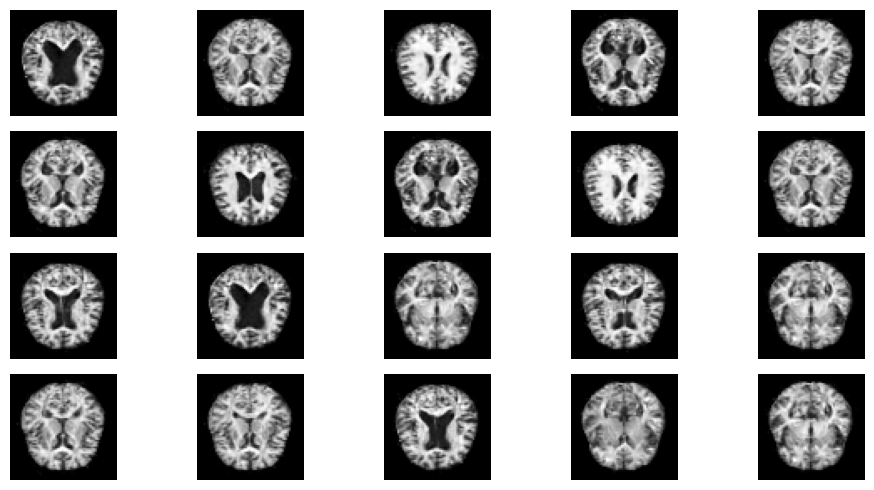

In [61]:
# noise_samples = torch.randn(20, 50, 1, 1).to(device)
# gen_labels = torch.randint(0, 4, (20,)).to(device)

# images = net_G(noise_samples, gen_labels)
# images.shape

# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))

# for index, image in enumerate(images):
#     image = image.detach().cpu().permute(1, 2, 0).numpy()
#     image = (image - image.min())/(image.max()-image.min())
#     plt.subplot(4, 5, index+1)
#     plt.imshow(image, cmap='gray')
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

In [35]:
dataloader.dataset

NameError: name 'dataloader' is not defined